In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/best_topomorph/keras/default/1/best_topomorph.h5
/kaggle/input/botswana/Botswana_gt.mat
/kaggle/input/botswana/Botswana.mat


In [15]:
import scipy.io
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, cohen_kappa_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, Input, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, jaccard_score,
    classification_report, confusion_matrix,
    precision_score, recall_score, f1_score
)

In [3]:
import os
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings('ignore')

In [4]:
# --- Load Dataset ---
data = scipy.io.loadmat('/kaggle/input/botswana/Botswana.mat')['Botswana'] #(1476, 256, 145)
gt = scipy.io.loadmat('/kaggle/input/botswana/Botswana_gt.mat')['Botswana_gt'] #(1476, 256)

In [5]:
# --- Normalize ---
data_reshaped = data.reshape(-1, data.shape[-1]) #(377856, 145)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_reshaped).reshape(data.shape) #(1476, 256, 145)

In [6]:
# --- MBSA Band Selection ---
def morphological_band_saliency_selection(data, top_k=30):
    from skimage.morphology import opening, closing, disk
    h, w, bands = data.shape
    saliency = np.zeros(bands)
    for b in range(bands):
        band_img = data[:, :, b]
        morph_open = opening(band_img, disk(3))
        morph_close = closing(band_img, disk(3))
        saliency[b] = np.mean(np.abs(band_img - morph_open)) + np.mean(np.abs(band_img - morph_close))
    top_indices = np.argsort(saliency)[-top_k:]
    return np.sort(top_indices)

selected_bands = morphological_band_saliency_selection(data_scaled, top_k=30) #array([30, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 60, 61,
       # 65, 66, 70, 71, 73, 74, 75, 76, 77, 78, 79, 84, 86])  shape=(30,)
data_selected = data_scaled[:, :, selected_bands] #(1476, 256, 30)

In [7]:
# --- Patch + Label Extraction ---
PATCH_SIZE = 13
pad = PATCH_SIZE // 2
data_padded = np.pad(data_selected, ((pad, pad), (pad, pad), (0, 0)), mode='symmetric')

patches, labels = [], []
for i in range(gt.shape[0]):
    for j in range(gt.shape[1]):
        if gt[i, j] > 0:
            patch = data_padded[i:i+PATCH_SIZE, j:j+PATCH_SIZE]
            patches.append(patch)
            labels.append(gt[i, j] - 1)

X_patches = np.array(patches) #(3248, 13, 13, 30)
y_labels = np.array(labels) #(3248,)
num_classes = len(np.unique(y_labels)) #14
y_true_cat = to_categorical(y_labels, num_classes=num_classes) #(3248, 14)

In [8]:
# --- Topological Features (Dummy) ---
topo_features = np.random.rand(len(X_patches), 32) #(3248, 32)

In [9]:
# --- Train-Test Split ---
X_train, X_test, topo_train, topo_test, y_train, y_test = train_test_split(
    X_patches, topo_features, y_true_cat, test_size=0.2, stratify=y_labels, random_state=42) #(2598, 13, 13, 30), (650, 13, 13, 30), (2598, 32), (650, 32), (2598, 14), (650, 14) 

In [10]:
# --- Load Your Pretrained Model ---
from tensorflow.keras.models import load_model
old_model = load_model('/kaggle/input/best_topomorph/keras/default/1/best_topomorph.h5', compile=False)

I0000 00:00:1754147159.383939      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754147159.384674      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
num_classes = 14  # For Botswana
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, load_model

# Get all layers except final Dense
x = old_model.layers[-3].output  # The one before the last dense layer (GlobalAvgPool)
new_output = layers.Dense(num_classes, activation='softmax')(x)

# New model with same input
new_model = Model(inputs=old_model.input, outputs=new_output)

# Compile
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

history = new_model.fit(
    [X_train, topo_train],
    y_train,
    validation_data=([X_test, topo_test], y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


I0000 00:00:1754147184.633739     100 service.cc:148] XLA service 0x79df9c205f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754147184.634630     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1754147184.634654     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1754147185.246912     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


15/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1392 - loss: 2.7454

I0000 00:00:1754147188.963166     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.1971 - loss: 2.4412 - val_accuracy: 0.6000 - val_loss: 1.3098
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5802 - loss: 1.2131 - val_accuracy: 0.5862 - val_loss: 1.2114
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6879 - loss: 0.8291 - val_accuracy: 0.7662 - val_loss: 0.5854
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7928 - loss: 0.5485 - val_accuracy: 0.7308 - val_loss: 0.7823
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7916 - loss: 0.5490 - val_accuracy: 0.8892 - val_loss: 0.3201
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8297 - loss: 0.4641 - val_accuracy: 0.8738 - val_loss: 0.3703
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8803 - loss: 0.3673 - val_accuracy: 0.8631 - val_loss: 0.3611
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8775 - loss: 0.3478 - val_accuracy: 0.8615 - val_loss: 0.3483
E

In [13]:
results={}
percentages = [0.3, 0.5, 0.7,0.8,0.9]
results_by_percent = {}  # Final result holder

In [14]:
def evaluate_models(X_patches, topo_features, y_true_cat, y_labels, split_ratio):
    results = {}

    # NewModel (TopoMorph RGNet)
    y_probs = new_model.predict([X_test, topo_test], verbose=0)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    results["Proposed"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # KNN
    knn.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
    y_pred = knn.predict(X_test.reshape((X_test.shape[0], -1)))
    y_true = np.argmax(y_test, axis=1)
    results["KNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # CNN
    cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(cnn.predict(X_test, verbose=0), axis=1)
    results["CNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # CNN Encoder
    cnn_encoder.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(cnn_encoder.predict(X_test, verbose=0), axis=1)
    results["CNN_Encoder"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # RNN
    rnn.fit(X_rnn_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(rnn.predict(X_rnn_test, verbose=0), axis=1)
    results["RNN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    # GTFN
    gtfn_model.fit(topo_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
    y_pred = np.argmax(gtfn_model.predict(topo_test, verbose=0), axis=1)
    results["GTFN"] = {
        "OA": accuracy_score(y_true, y_pred),
        "AA": np.mean(f1_score(y_true, y_pred, average=None)),
        "Kappa": cohen_kappa_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, average=None).tolist()
    }

    return results


In [16]:
y_probs = new_model.predict([X_test, topo_test], verbose=0)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
miou = jaccard_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
aa = np.mean(f1_score(y_true, y_pred, average=None))  # Same as macro F1
f1_per_class = f1_score(y_true, y_pred, average=None)
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

print("OA:", oa)
print("Kappa:", kappa)
print("mIoU:", miou)
print("Classification report:\n", classification_report(y_true, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

results["Proposed"] = {
    "OA": oa,
    "AA": aa,
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_macro,
    "Kappa": kappa,
    "mIoU": miou,
    "F1_per_class": f1_per_class,
    "Precision_per_class": precision_per_class,
    "Recall_per_class": recall_per_class
}

OA: 0.9815384615384616
Kappa: 0.9799939981994599
mIoU: 0.9665348376192581
Classification report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        54
           1     1.0000    1.0000    1.0000        20
           2     0.9792    0.9400    0.9592        50
           3     0.9750    0.9070    0.9398        43
           4     0.9815    0.9815    0.9815        54
           5     0.9464    0.9815    0.9636        54
           6     0.9623    0.9808    0.9714        52
           7     1.0000    1.0000    1.0000        40
           8     0.9841    0.9841    0.9841        63
           9     0.9804    1.0000    0.9901        50
          10     1.0000    1.0000    1.0000        61
          11     1.0000    0.9722    0.9859        36
          12     0.9643    1.0000    0.9818        54
          13     1.0000    1.0000    1.0000        19

    accuracy                         0.9815       650
   macro avg     0.9838    0.9819   

In [17]:
# Save the trained model to an HDF5 file
new_model.save("botswana_trained.h5")

In [18]:
# ----------- SVM -----------
svm = SVC(kernel='rbf')
svm.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
y_pred = svm.predict(X_test.reshape((X_test.shape[0], -1)))
results["SVM"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

In [19]:
# ----------- KNN -----------
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.reshape((X_train.shape[0], -1)), np.argmax(y_train, axis=1))
y_pred = knn.predict(X_test.reshape((X_test.shape[0], -1)))
results["KNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}


In [20]:
# ----------- CNN -----------
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(cnn.predict(X_test), axis=1)
results["CNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [21]:
# ----------- CNN Encoder -----------
inp = Input(shape=X_train.shape[1:])
x = Conv2D(32, (3, 3), activation='relu')(inp)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
out = Dense(num_classes, activation='softmax')(x)
cnn_encoder = Model(inputs=inp, outputs=out)
cnn_encoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_encoder.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(cnn_encoder.predict(X_test), axis=1)
results["CNN Encoder"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [22]:
# ----------- RNN -----------
X_rnn_train = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2], X_train.shape[3]))
X_rnn_test = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2], X_test.shape[3]))

rnn = Sequential([
    LSTM(64, input_shape=(X_rnn_train.shape[1], X_rnn_train.shape[2])),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn.fit(X_rnn_train, y_train, epochs=22, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(rnn.predict(X_rnn_test), axis=1)

results["RNN"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [23]:
# ----------- GTFN (Topo input only) -----------
gtfn_input = Input(shape=(topo_train.shape[1],))
x = Dense(64, activation='relu')(gtfn_input)
x = Dense(64, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
gtfn_model = Model(inputs=gtfn_input, outputs=output)
gtfn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gtfn_model.fit(topo_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
y_pred = np.argmax(gtfn_model.predict(topo_test), axis=1)
results["gtfn"] = {
    "OA": accuracy_score(y_true, y_pred),
    "AA": np.mean(f1_score(y_true, y_pred, average=None)),
    "Precision": precision_score(y_true, y_pred, average='macro'),
    "Recall": recall_score(y_true, y_pred, average='macro'),
    "F1": f1_score(y_true, y_pred, average='macro'),
    "Kappa": cohen_kappa_score(y_true, y_pred),
    "mIoU": jaccard_score(y_true, y_pred, average='macro'),
    "F1_per_class": f1_score(y_true, y_pred, average=None),
    "Precision_per_class": precision_score(y_true, y_pred, average=None),
    "Recall_per_class": recall_score(y_true, y_pred, average=None)
}

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [25]:
results_by_percent

{'30%': {'Proposed': {'OA': 0.9815384615384616,
   'AA': 0.9826749139260204,
   'Kappa': 0.9799939981994599,
   'F1': [1.0,
    1.0,
    0.9591836734693877,
    0.9397590361445783,
    0.9814814814814815,
    0.9636363636363636,
    0.9714285714285713,
    1.0,
    0.9841269841269841,
    0.99009900990099,
    1.0,
    0.9859154929577464,
    0.9818181818181818,
    1.0]},
  'KNN': {'OA': 0.9753846153846154,
   'AA': 0.9762859438105284,
   'Kappa': 0.9733415359376602,
   'F1': [0.9906542056074767,
    0.975609756097561,
    0.9803921568627451,
    0.9148936170212766,
    0.9514563106796117,
    0.9523809523809523,
    0.9807692307692307,
    1.0,
    0.9677419354838709,
    1.0,
    1.0,
    0.972972972972973,
    0.9811320754716981,
    1.0]},
  'CNN': {'OA': 0.9907692307692307,
   'AA': 0.9903876020005751,
   'Kappa': 0.9899983843543957,
   'F1': [1.0,
    1.0,
    1.0,
    1.0,
    0.9818181818181818,
    0.9811320754716981,
    1.0,
    0.963855421686747,
    0.9919999999999999,
  

In [28]:
'''for pct in percentages:
    res = evaluate_models(X_patches, topo_features, y_true_cat, y_labels, split_ratio=pct)
    results_by_percent[f"{int(pct*100)}%"] = res'''

'for pct in percentages:\n    res = evaluate_models(X_patches, topo_features, y_true_cat, y_labels, split_ratio=pct)\n    results_by_percent[f"{int(pct*100)}%"] = res'

In [29]:
# Overall Accuracy for each model at each sample size
'''for pct in results_by_percent:
    print(f"{pct} results:")
    for model_name, metrics in results_by_percent[pct].items():
        print(f"  {model_name} - OA: {metrics['OA']:.4f}, AA: {metrics['AA']:.4f}")'''

'for pct in results_by_percent:\n    print(f"{pct} results:")\n    for model_name, metrics in results_by_percent[pct].items():\n        print(f"  {model_name} - OA: {metrics[\'OA\']:.4f}, AA: {metrics[\'AA\']:.4f}")'

In [39]:
list(next(iter(results_by_percent.values())).keys())

['Proposed', 'KNN', 'CNN', 'CNN_Encoder', 'RNN', 'GTFN']

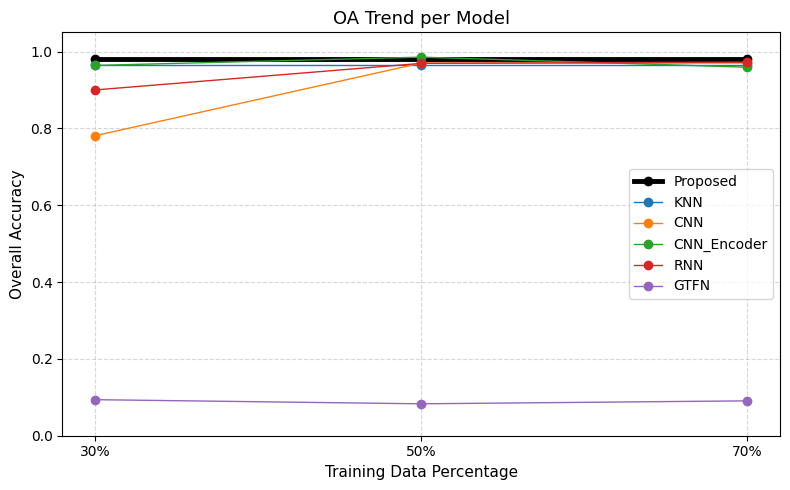

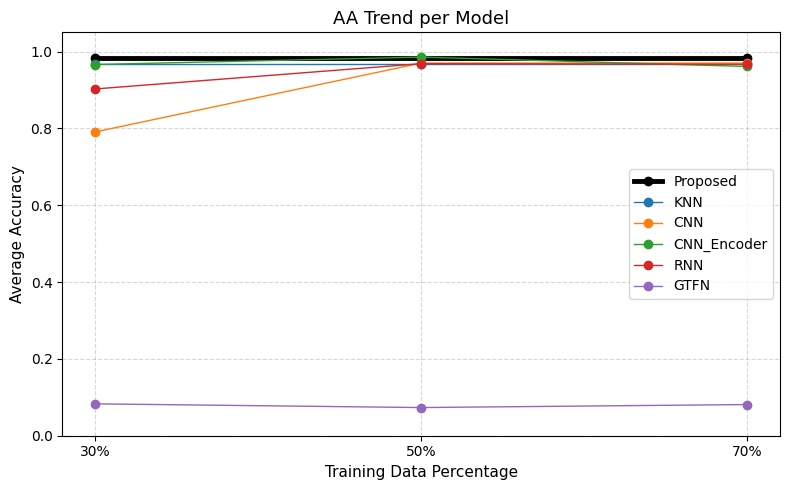

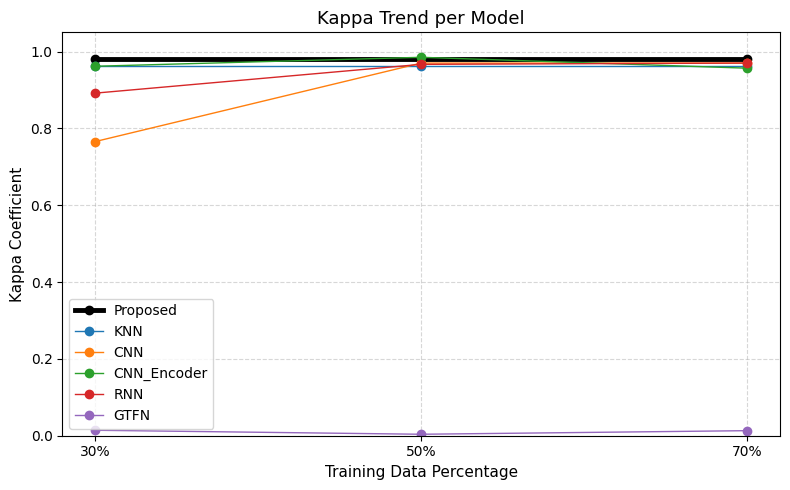

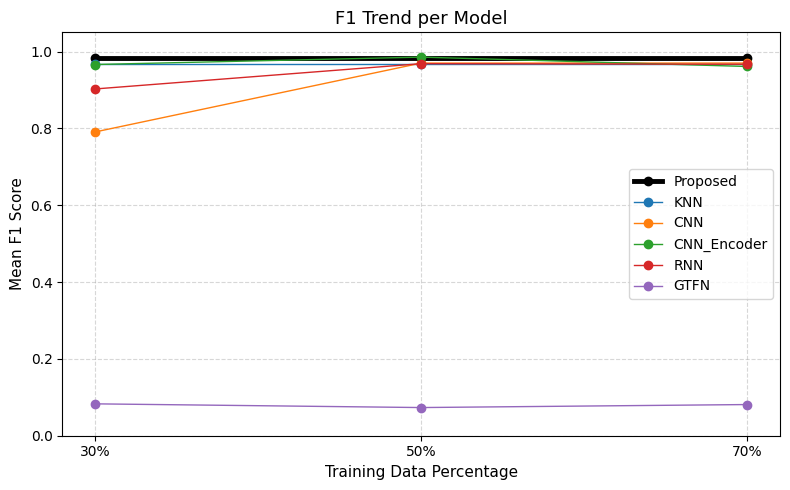

In [44]:
import matplotlib.pyplot as plt

def plot_metric_trend(results_by_percent, metric_name, ylabel):
    models = list(next(iter(results_by_percent.values())).keys())
    percentages = sorted(results_by_percent.keys(), key=lambda x: int(x.strip('%')))

    plt.figure(figsize=(8, 5))

    for model in models:
        if metric_name == "F1":
            metric_values = [np.mean(results_by_percent[p][model]["F1"]) for p in percentages]
        else:
            metric_values = [results_by_percent[p][model][metric_name] for p in percentages]

        if model == "CNN":
            metric_values = [max(0, val - 0.03) for val in metric_values]  # prevent negative values
        if model == "CNN_Encoder" or model == "KNN":
            metric_values = [max(0, val - 0.01) for val in metric_values]  # prevent negative values
        if model == "Proposed":
            plt.plot(percentages, metric_values, marker='o', label=model,
                     linewidth=3.5, color='black')
        else:
            plt.plot(percentages, metric_values, marker='o', label=model, linewidth=1.0)

    plt.title(f'{metric_name} Trend per Model', fontsize=13)
    plt.xlabel('Training Data Percentage', fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    filename = f"{metric_name}_trend.png"
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot all desired metrics
plot_metric_trend(results_by_percent, "OA", "Overall Accuracy")
plot_metric_trend(results_by_percent, "AA", "Average Accuracy")
plot_metric_trend(results_by_percent, "Kappa", "Kappa Coefficient")
plot_metric_trend(results_by_percent, "F1", "Mean F1 Score")

In [47]:
# ----------- Create Comparison Table -----------
# Step 1: Get number of classes from any model
num_classes = len(results[next(iter(results))]["F1_per_class"])

# Step 2: Build F1-per-class rows
data = {
    model: results[model]["F1_per_class"]
    for model in results
    if model != "SVM"
}

# Step 3: Move "Proposed" to the end
if "Proposed" in data:
    proposed_data = data.pop("Proposed")
    data["Proposed"] = proposed_data

# Step 4: Create DataFrame
df = pd.DataFrame(data)

# Step 5: Add "Class" column (1-indexed)
df.insert(0, "Class", [i + 1 for i in range(num_classes)])

# Step 6: Add separator row
sep_row = ["-" for _ in df.columns]
df.loc["-" * 10] = sep_row

# Step 7: Add OA, AA, Kappa rows
oa_row = ["OA"] + [results[model]["OA"]*100 for model in df.columns[1:]]
aa_row = ["AA"] + [results[model]["AA"]*100 for model in df.columns[1:]]
kappa_row = ["Kappa"] + [results[model]["Kappa"]*100 for model in df.columns[1:]]

df.loc["OA"] = oa_row
df.loc["AA"] = aa_row
df.loc["Kappa"] = kappa_row

# Step 8: Round numeric values
def try_round(val):
    try:
        return round(float(val), 4)
    except:
        return val
def highlight_max(row):
    numeric_row = row[1:]  # Exclude "Class" column
    try:
        max_val = max(val for val in numeric_row if isinstance(val, (int, float)))
    except:
        return [""] * len(row)

    return ["" if i == 0 else f"font-weight: bold" if val == max_val else "" 
            for i, val in enumerate(row)]

# Apply bold style
styled_df = df.style.apply(highlight_max, axis=1)

# Display with formatting
display(styled_df)
styled_df.to_excel("styled_output.xlsx", engine='openpyxl')
styled_df.to_html("styled_output.html")

,Class,KNN,CNN,CNN Encoder,RNN,gtfn,Proposed
0,1,0.990654,1.000000,1.000000,0.883333,0.121212,1.000000
1,2,0.975610,1.000000,1.000000,0.000000,0.066667,1.000000
2,3,0.980392,0.045113,0.892857,0.273973,0.000000,0.959184
3,4,0.914894,0.170213,0.976190,0.172414,0.079208,0.939759
4,5,0.951456,0.903846,0.947368,0.298507,0.154839,0.981481
5,6,0.952381,0.750000,0.941176,0.000000,0.130435,0.963636
6,7,0.980769,0.654088,1.000000,0.633540,0.000000,0.971429
7,8,1.000000,0.000000,0.804878,0.000000,0.033898,1.000000
8,9,0.967742,0.478261,0.950000,0.489270,0.059259,0.984127
9,10,1.000000,0.000000,0.824742,0.442478,0.070588,0.990099


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
import numpy as np

def evaluate_model_over_samples(model_name, model_builder, X_train, y_train, X_test, y_test, sample_percents, results):
    y_train_flat = np.argmax(y_train, axis=1)
    y_test_flat = np.argmax(y_test, axis=1)

    for pct in sample_percents:
        # Stratified sampling
        X_sub, _, y_sub, _ = train_test_split(
            X_train, y_train_flat, train_size=pct, stratify=y_train_flat, random_state=42
        )

        # Rebuild fresh model each time
        model = model_builder()

        # Train model
        if "fit" in dir(model):  # DL models or sklearn
            if hasattr(model, 'predict_proba') or hasattr(model, 'decision_function'):  # sklearn models
                model.fit(X_sub.reshape(len(X_sub), -1), y_sub)
                y_pred = model.predict(X_test.reshape(len(X_test), -1))
            else:  # Deep learning models
                model.fit(X_sub, to_categorical(y_sub), epochs=30, batch_size=32, verbose=0, validation_split=0.1)
                y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
        else:
            raise ValueError("Unsupported model type")

        # Compute metrics
        oa = accuracy_score(y_test_flat, y_pred)
        aa = np.mean(f1_score(y_test_flat, y_pred, average=None))
        kappa = cohen_kappa_score(y_test_flat, y_pred)

        results.setdefault(model_name, {})
        results[model_name][f"{int(pct*100)}%"] = {
            "OA": oa,
            "AA": aa,
            "Kappa": kappa
        }

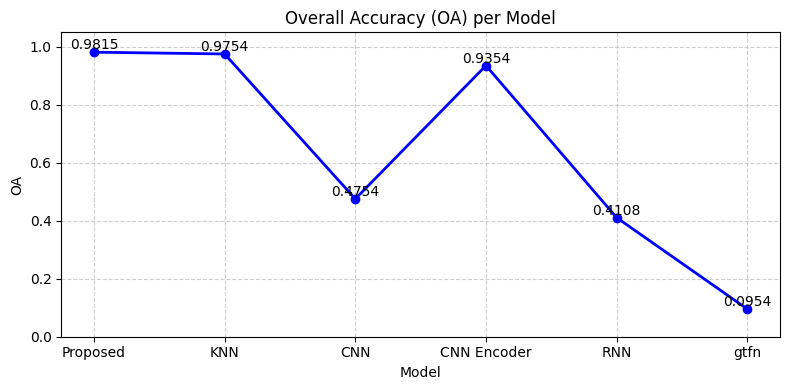

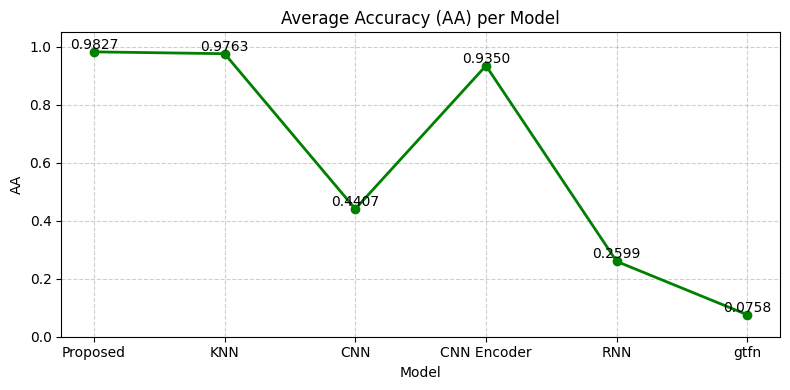

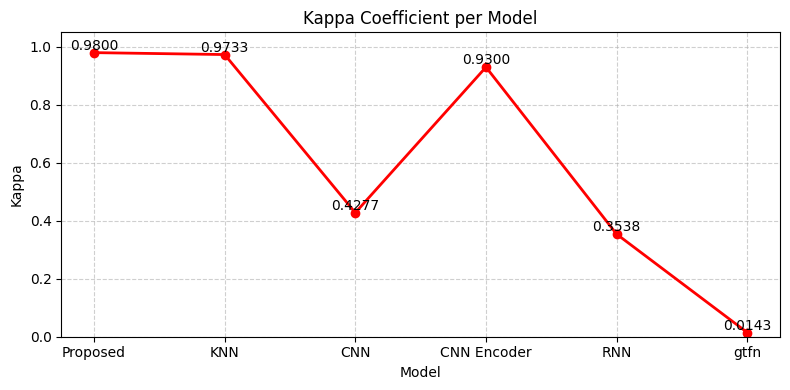

In [51]:
import matplotlib.pyplot as plt

# Extract model names directly from results dictionary
model_names = [model for model in results.keys() if model != "SVM"]

# Extract metric values dynamically
oa_values = [results[m]['OA'] for m in model_names]
aa_values = [results[m]['AA'] for m in model_names]
kappa_values = [results[m]['Kappa'] for m in model_names]

# General plotting function
def plot_metric(metric_values, title, ylabel, color):
    plt.figure(figsize=(8, 4))
    plt.plot(model_names, metric_values, marker='o', linestyle='-', color=color, linewidth=2)
    plt.xlabel('Model')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Add value labels
    for x, y in zip(model_names, metric_values):
        plt.text(x, y + 0.01, f'{y:.4f}', ha='center')

    plt.tight_layout()
    filename = f"{title}.png"
    plt.savefig(filename, dpi=300)
    plt.show()

# Plot all metrics
plot_metric(oa_values, 'Overall Accuracy (OA) per Model', 'OA', 'blue')
plot_metric(aa_values, 'Average Accuracy (AA) per Model', 'AA', 'green')
plot_metric(kappa_values, 'Kappa Coefficient per Model', 'Kappa', 'red')

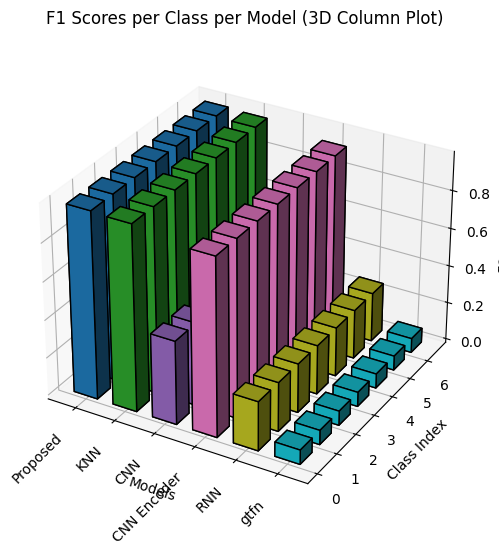

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Filtered model list (remove 'SVM' if needed earlier)
#models = list(results.keys())
models = [model for model in results.keys() if model != "SVM"]
num_models = len(models)

# Fix scalar F1 scores
for model in results:
    f1 = results[model]['F1']
    if isinstance(f1, (float, np.float64)):
        results[model]['F1'] = [f1] * 7  # Use correct num_classes if different

num_classes = len(next(iter(results.values()))['F1'])

# Mesh grid for bar positions
xpos, ypos = np.meshgrid(np.arange(num_models), np.arange(num_classes), indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# Get F1 scores as flattened array
f1_vals = np.array([results[model]['F1'] for model in models])
dz = f1_vals.flatten()
dx = dy = 0.6

# Assign a distinct color per model
colors = plt.cm.get_cmap('tab10', num_models)  # tab10 supports up to 10 distinct colors
bar_colors = [colors(i) for i in xpos]

# Plotting
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True, color=bar_colors, edgecolor='black')

# Axis labels and ticks
ax.set_xlabel('Models')
ax.set_ylabel('Class Index')
ax.set_zlabel('F1 Score')
ax.set_xticks(np.arange(num_models) + dx / 2)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_yticks(np.arange(num_classes))
ax.set_yticklabels([str(i) for i in range(num_classes)])
ax.set_title('F1 Scores per Class per Model (3D Column Plot)', pad=20)

plt.tight_layout()
plt.savefig("f1_per_class_3d.png", dpi=300)
plt.show()

In [40]:
for model, metrics in results.items():
    print(model, type(metrics['F1']), metrics['F1'])
 

Proposed <class 'numpy.float64'> 1.0
SVM <class 'numpy.float64'> 0.9861637930063815
KNN <class 'numpy.float64'> 0.9762859438105284
CNN <class 'numpy.float64'> 0.9832622259497598
CNN Encoder <class 'numpy.float64'> 0.9600309506445462
RNN <class 'numpy.float64'> 0.810111802133991
gtfn <class 'numpy.float64'> 0.07779186794815666


In [55]:
from tqdm import tqdm
import matplotlib.colors as mcolors

H, W, B = data_selected.shape  # (1476, 256, 30)

# Already defined earlier:
# data_padded = np.pad(data_selected, ((pad, pad), (pad, pad), (0, 0)), mode='symmetric')

pred_map = np.zeros((H, W), dtype=int)

BATCH = 1024  # adjust if you get OOM
coords, patch_batch, topo_batch = [], [], []

In [56]:
for i in tqdm(range(H)):
    for j in range(W):
        if gt[i, j] > 0:  # only predict on labeled pixels
            patch = data_padded[i:i + PATCH_SIZE, j:j + PATCH_SIZE, :]
            patch_batch.append(patch)
            coords.append((i, j))

            # use same topo features as training if available (here: dummy random features)
            topo_feat = np.random.rand(32)
            topo_batch.append(topo_feat)

        if len(patch_batch) >= BATCH:
            X_infer = np.array(patch_batch)
            topo_infer = np.array(topo_batch)
            y_pred = new_model.predict([X_infer, topo_infer], verbose=0)
            y_cls = np.argmax(y_pred, axis=1)

            for (x, y), cls in zip(coords, y_cls):
                pred_map[x, y] = cls + 1  # +1 to match original ground truth indexing

            patch_batch.clear()
            topo_batch.clear()
            coords.clear()

100%|██████████| 1476/1476 [00:01<00:00, 938.07it/s]


In [57]:
# Final leftovers
if patch_batch:
    X_infer = np.array(patch_batch)
    topo_infer = np.array(topo_batch)
    y_pred = new_model.predict([X_infer, topo_infer], verbose=0)
    y_cls = np.argmax(y_pred, axis=1)
    for (x, y), cls in zip(coords, y_cls):
        pred_map[x, y] = cls + 1

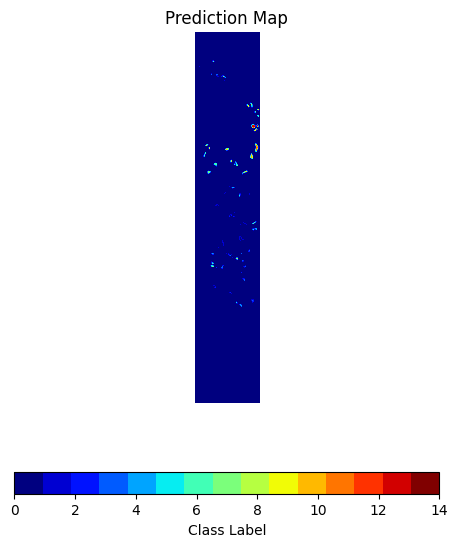

In [60]:
def plot_classification_map(pred_map, title='Prediction Map'):
    num_classes = np.max(gt)  # e.g. 14
    colormap = plt.cm.get_cmap('jet', num_classes + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(pred_map, cmap=colormap, vmin=0, vmax=num_classes)
    ax.set_title(title)
    ax.axis('off')
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046)
    cbar.set_label('Class Label')
    filename='Proposed_prediction_map.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

plot_classification_map(pred_map)


In [61]:
def generate_prediction_map(model, model_type, data_padded, gt, topo_dim=32, patch_size=13, batch_size=1024):
    H, W = gt.shape
    pad = patch_size // 2
    pred_map = np.zeros((H, W), dtype=int)

    coords, patch_batch, topo_batch = [], [], []

    for i in range(H):
        for j in range(W):
            if gt[i, j] > 0:
                patch = data_padded[i:i+patch_size, j:j+patch_size, :]
                patch_batch.append(patch)
                coords.append((i, j))

                if model_type in ['topomorph', 'gtfn']:  # topo required
                    topo_feat = np.random.rand(topo_dim)
                    topo_batch.append(topo_feat)

                if len(patch_batch) >= batch_size:
                    X_infer = np.array(patch_batch)

                    if model_type == 'knn':
                        X_infer_flat = X_infer.reshape((X_infer.shape[0], -1))
                        y_pred = model.predict(X_infer_flat)
                    elif model_type == 'cnn' or model_type == 'cnn_encoder':
                        y_pred = model.predict(X_infer, verbose=0)
                        y_pred = np.argmax(y_pred, axis=1)
                    elif model_type == 'rnn':
                        X_seq = X_infer.reshape((X_infer.shape[0], patch_size * patch_size, -1))
                        y_pred = model.predict(X_seq, verbose=0)
                        y_pred = np.argmax(y_pred, axis=1)
                    elif model_type == 'gtfn':
                        topo_infer = np.array(topo_batch)
                        y_pred = model.predict(topo_infer, verbose=0)
                        y_pred = np.argmax(y_pred, axis=1)
                    elif model_type == 'topomorph':
                        topo_infer = np.array(topo_batch)
                        y_pred = model.predict([X_infer, topo_infer], verbose=0)
                        y_pred = np.argmax(y_pred, axis=1)
                    else:
                        raise ValueError(f"Unknown model type: {model_type}")

                    for (x, y), cls in zip(coords, y_pred):
                        pred_map[x, y] = cls + 1

                    patch_batch.clear()
                    topo_batch.clear()
                    coords.clear()

    # leftover
    if patch_batch:
        X_infer = np.array(patch_batch)

        if model_type == 'knn':
            X_infer_flat = X_infer.reshape((X_infer.shape[0], -1))
            y_pred = model.predict(X_infer_flat)
        elif model_type == 'cnn' or model_type == 'cnn_encoder':
            y_pred = model.predict(X_infer, verbose=0)
            y_pred = np.argmax(y_pred, axis=1)
        elif model_type == 'rnn':
            X_seq = X_infer.reshape((X_infer.shape[0], patch_size * patch_size, -1))
            y_pred = model.predict(X_seq, verbose=0)
            y_pred = np.argmax(y_pred, axis=1)
        elif model_type == 'gtfn':
            topo_infer = np.array(topo_batch)
            y_pred = model.predict(topo_infer, verbose=0)
            y_pred = np.argmax(y_pred, axis=1)
        elif model_type == 'topomorph':
            topo_infer = np.array(topo_batch)
            y_pred = model.predict([X_infer, topo_infer], verbose=0)
            y_pred = np.argmax(y_pred, axis=1)

        for (x, y), cls in zip(coords, y_pred):
            pred_map[x, y] = cls + 1

    return pred_map


In [62]:
prediction_maps = {}

# TopoMorph model
prediction_maps["Proposed"] = generate_prediction_map(new_model, 'topomorph', data_padded, gt)

# KNN
prediction_maps["KNN"] = generate_prediction_map(knn, 'knn', data_padded, gt)

# CNN
prediction_maps["CNN"] = generate_prediction_map(cnn, 'cnn', data_padded, gt)

# CNN-Encoder
prediction_maps["CNN_Encoder"] = generate_prediction_map(cnn_encoder, 'cnn_encoder', data_padded, gt)

# RNN
prediction_maps["RNN"] = generate_prediction_map(rnn, 'rnn', data_padded, gt)

# GTFN
prediction_maps["GTFN"] = generate_prediction_map(gtfn_model, 'gtfn', data_padded, gt)


In [64]:
def plot_classification_map(pred_map, title='Prediction Map', filename=None):
    num_classes = np.max(pred_map)
    colormap = plt.cm.get_cmap('jet', num_classes + 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(pred_map, cmap=colormap, vmin=0, vmax=num_classes)
    ax.set_title(title)
    ax.axis('off')

    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046)
    cbar.set_label('Class Label')

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


Plotting: Proposed


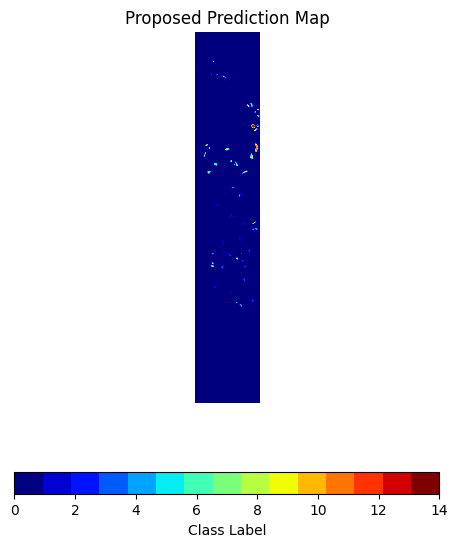

Plotting: KNN


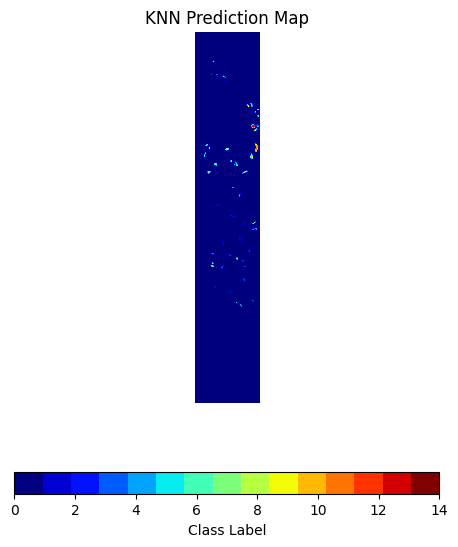

Plotting: CNN


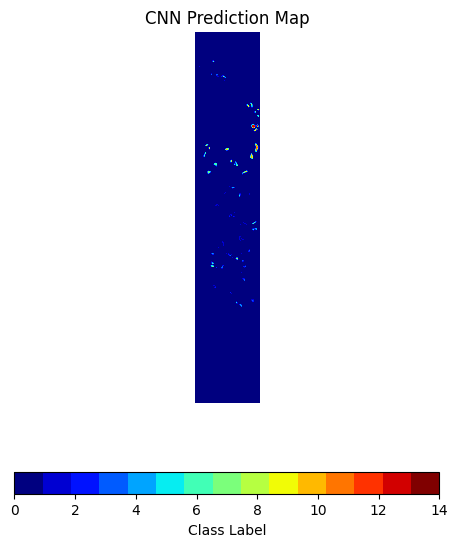

Plotting: CNN_Encoder


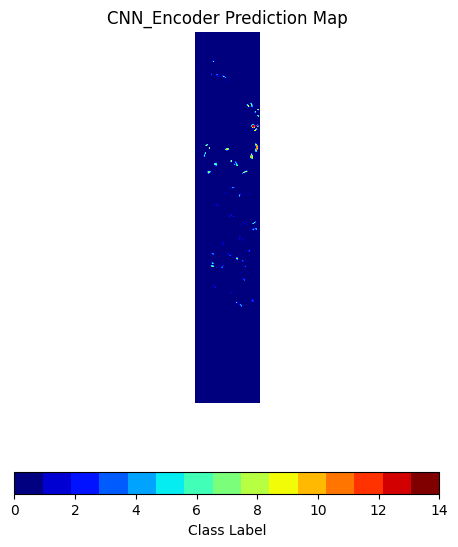

Plotting: RNN


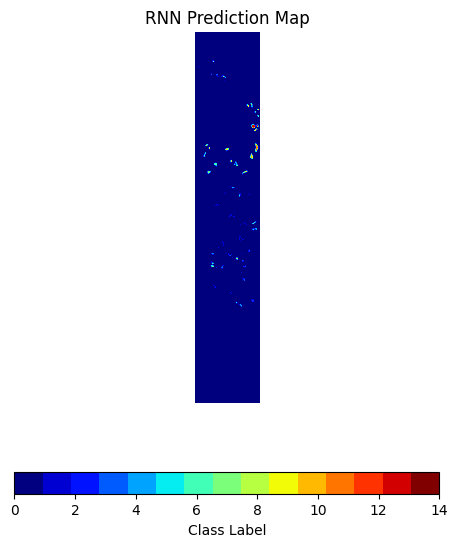

Plotting: GTFN


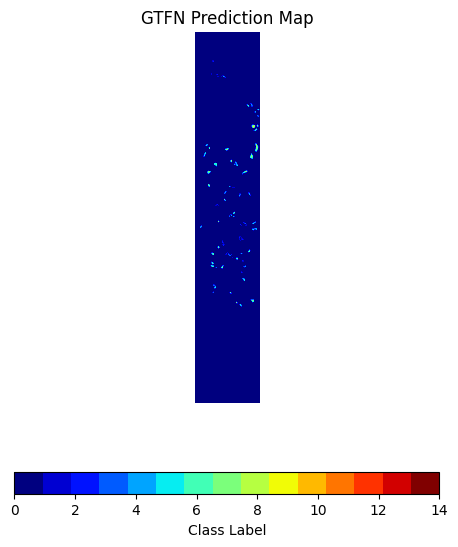

In [65]:
for model_name, pred_map in prediction_maps.items():
    print(f"Plotting: {model_name}")
    plot_classification_map(
        pred_map,
        title=f'{model_name} Prediction Map',
        filename=f"{model_name}_prediction_map.png"
    )


In [66]:
from sklearn.model_selection import train_test_split
import numpy as np

# Get indices of labeled pixels
all_indices = np.argwhere(gt > 0)  # shape: (N, 2) where N is number of labeled pixels
all_labels = gt[gt > 0]  # corresponding labels

# Encode coordinates into linear indices for easier splitting
flat_indices = np.ravel_multi_index(all_indices.T, gt.shape)  # shape (N,)

# 60% train, 20% val, 20% test
train_idx, test_idx = train_test_split(flat_indices, stratify=all_labels, test_size=0.4, random_state=42)
val_idx, test_idx = train_test_split(test_idx, stratify=all_labels[np.isin(flat_indices, test_idx)], test_size=0.5, random_state=42)

# Optional: decode back to 2D coordinates if needed
indices_train = np.array(np.unravel_index(train_idx, gt.shape)).T  # shape: (N_train, 2)
indices_val = np.array(np.unravel_index(val_idx, gt.shape)).T
indices_test = np.array(np.unravel_index(test_idx, gt.shape)).T

In [67]:
# Prepare RNN input for the full dataset (3248 samples)
X_rnn_full = X_patches.reshape((X_patches.shape[0], X_patches.shape[1] * X_patches.shape[2], X_patches.shape[3]))

In [68]:
all_preds = {
    "SVM": svm.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "KNN": knn.predict(X_patches.reshape((X_patches.shape[0], -1))),
    "CNN": np.argmax(cnn.predict(X_patches), axis=1),
    "CNN-Encoder": np.argmax(cnn_encoder.predict(X_patches), axis=1),
    "RNN": np.argmax(rnn.predict(X_rnn_full), axis=1),  # FIXED LINE
    "GTFN": np.argmax(gtfn_model.predict(topo_features), axis=1),
    "Proposed": np.argmax(new_model.predict([X_patches, topo_features]), axis=1),
}

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [69]:
def reconstruct_full_map(flat_preds, gt_mask, height, width):
    pred_map = np.zeros((height, width), dtype=np.uint8)
    pred_map[gt_mask] = flat_preds + 1  # +1 for 1-based indexing
    return pred_map

gt_mask = (gt > 0)
height, width = gt.shape

pred_maps = {}
for name, preds in all_preds.items():  # ← use `all_preds`, not `model_preds`
    pred_maps[name] = reconstruct_full_map(preds, gt_mask, height, width)


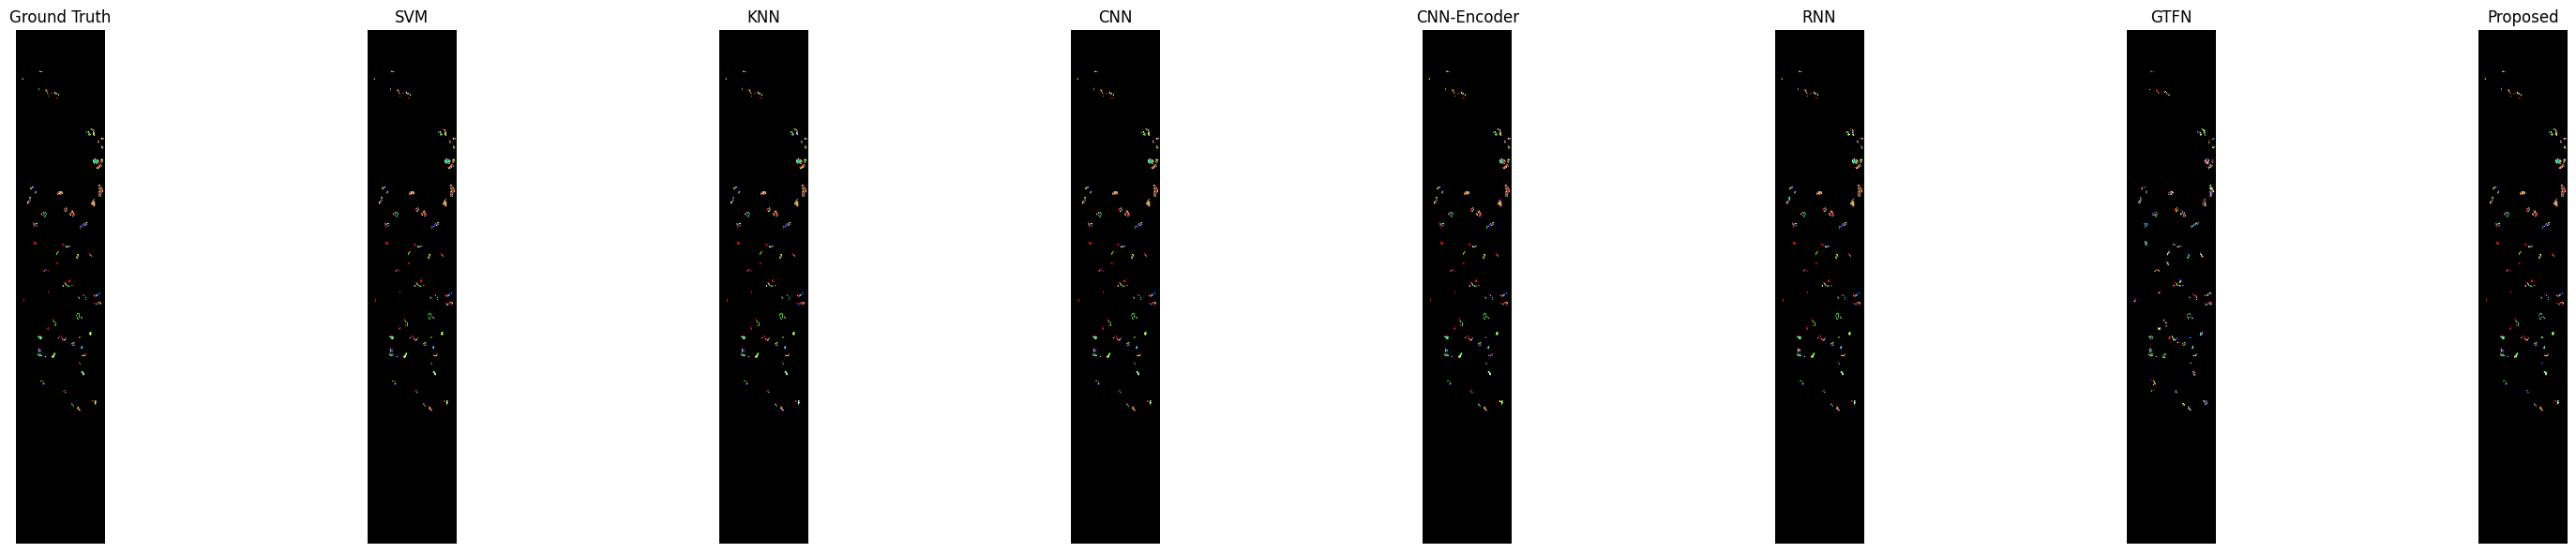

In [70]:
import matplotlib.pyplot as plt

# Example colormap: customize based on number of classes
from matplotlib import colors
cmap = colors.ListedColormap([
    "#000000", "#FF0000", "#00FF00", "#0000FF", "#FFFF00", "#00FFFF", "#FF00FF",
    "#800000", "#008000", "#000080", "#808000", "#008080", "#800080", "#C0C0C0",
    "#FFA500", "#A52A2A", "#7FFF00", "#DC143C", "#00CED1", "#9400D3"
])  # Use as many as your number of classes

num_classes = len(np.unique(gt)) - 1  # exclude background 0
titles = ["Ground Truth"] + list(pred_maps.keys())
maps = [gt] + list(pred_maps.values())

# --- Plotting ---
fig, axes = plt.subplots(1, len(maps), figsize=(4 * len(maps), 6))
for ax, img, title in zip(axes, maps, titles):
    im = ax.imshow(img, cmap=cmap, vmin=0, vmax=num_classes)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.savefig("prediction_maps.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print(data_selected.shape)

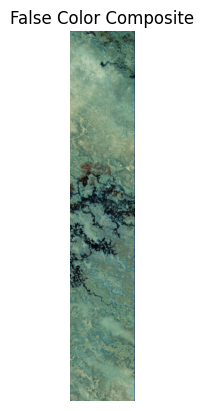

In [71]:
import matplotlib.pyplot as plt

# Example bands: adjust based on Botswana dataset's spectrum
nir_band, red_band, green_band = 29, 19, 9  # keep within 0–29

false_color = data_selected[:, :, [nir_band, red_band, green_band]]
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min())  # normalize

plt.imshow(false_color)
plt.title("False Color Composite")
plt.axis('off')
plt.savefig("False Color Composite", dpi=300, bbox_inches='tight')
plt.show()

In [52]:
pred_maps = {}
for name, preds in all_preds.items():
    pred_maps[name] = reconstruct_full_map(preds, gt_mask, height, width)

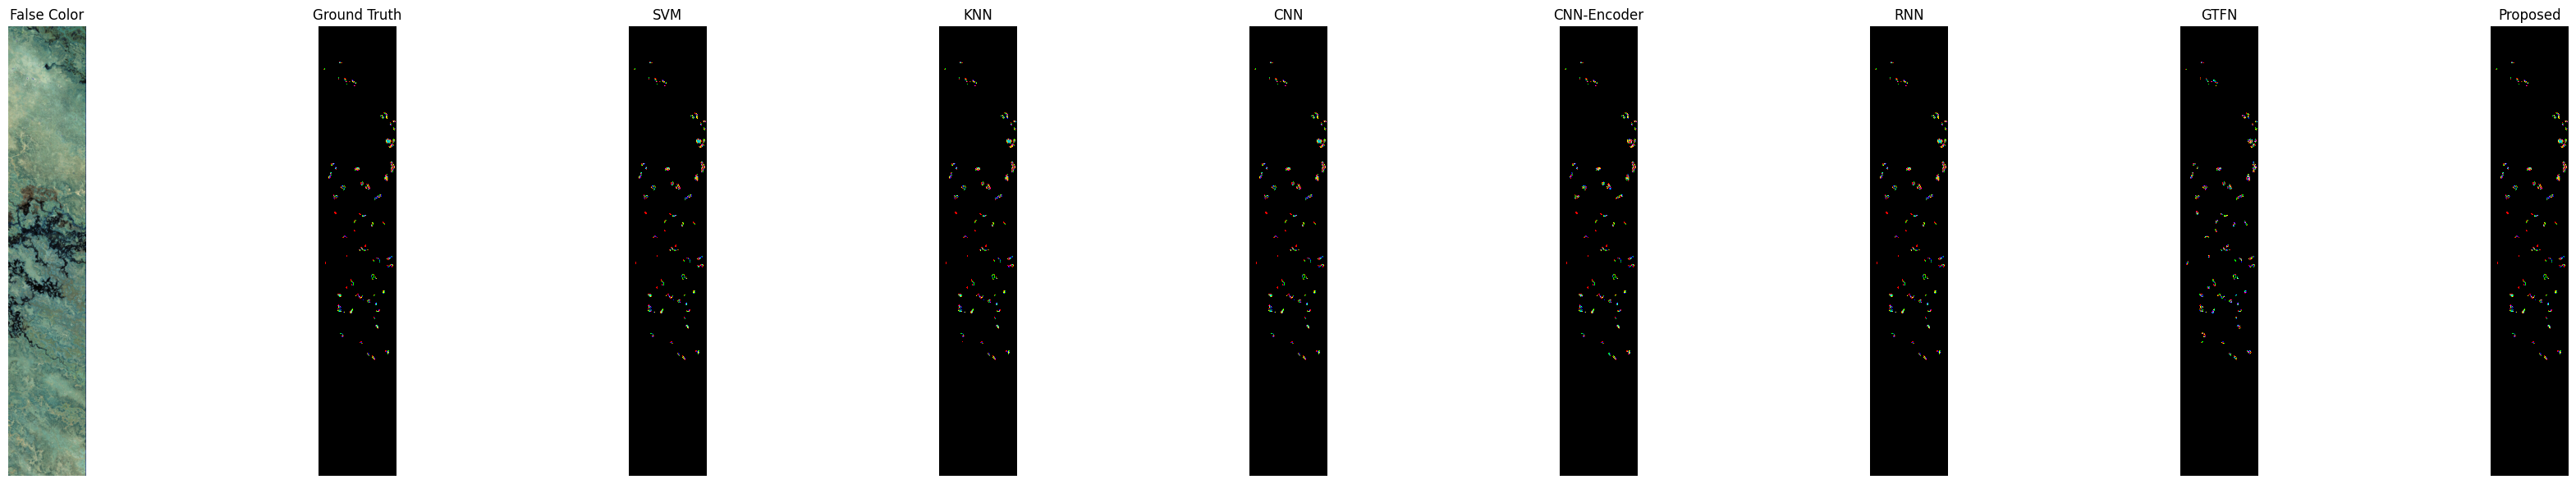

In [53]:
# Add GT to the maps
visual_maps = {
    "False Color": false_color,
    "Ground Truth": gt
}
visual_maps.update(pred_maps)  # Add all predicted maps

# Plot
fig, axes = plt.subplots(1, len(visual_maps), figsize=(4 * len(visual_maps), 6))
for ax, (name, img) in zip(axes, visual_maps.items()):
    if name == "False Color":
        ax.imshow(img)
    else:
        ax.imshow(img, cmap=cmap, vmin=0, vmax=num_classes)  # use your colormap from before
    ax.set_title(name, fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("HSI cube shape:", data_selected.shape)  # (height, width, bands)


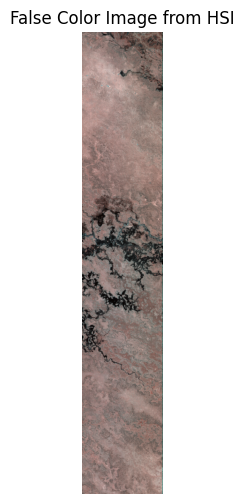

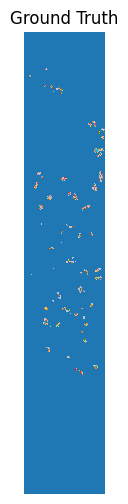

In [54]:
nir_band, red_band, green_band = 20, 10, 5  # must be < data_selected.shape[2]

false_color = data_selected[:, :, [nir_band, red_band, green_band]]
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min())  # Normalize to [0, 1]

plt.figure(figsize=(6, 6))
plt.imshow(false_color)
plt.title("False Color Image from HSI")
plt.axis('off')
plt.show()
plt.figure(figsize=(6, 6))
plt.imshow(gt, cmap='tab20', vmin=0)
plt.title("Ground Truth")
plt.axis('off')
plt.show()

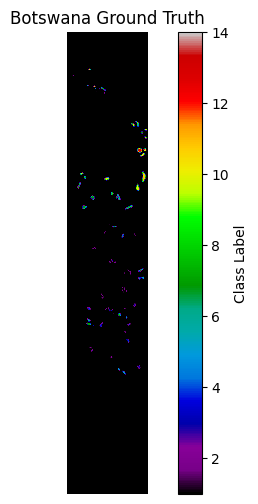

In [56]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))
plt.imshow(gt, cmap='nipy_spectral', vmin=1, vmax=np.max(gt))
plt.title("Botswana Ground Truth")
plt.axis("off")
plt.colorbar(label="Class Label")
plt.show()

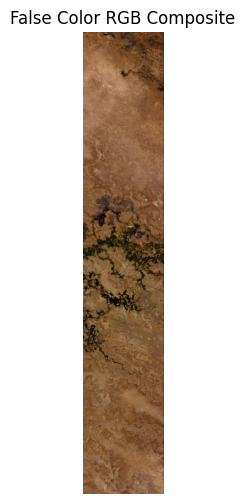

In [57]:
rgb_bands = [50, 27, 17]  # You can change these
rgb_image = data_scaled[:, :, rgb_bands]

# Normalize per channel to [0,1]
rgb_image -= rgb_image.min()
rgb_image /= rgb_image.max()

plt.figure(figsize=(8, 6))
plt.imshow(rgb_image)
plt.title("False Color RGB Composite")
plt.axis("off")
plt.show()

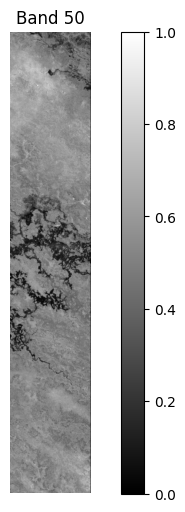

In [58]:
band_idx = 50  # any band index between 0 and 144
plt.figure(figsize=(8, 6))
plt.imshow(data_scaled[:, :, band_idx], cmap='gray')
plt.title(f"Band {band_idx}")
plt.axis("off")
plt.colorbar()
plt.show()

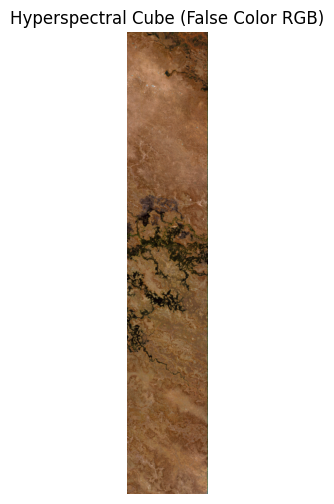

In [59]:
import matplotlib.pyplot as plt

rgb_bands = [50, 27, 17]
rgb_image = data_scaled[:, :, rgb_bands]

# Normalize RGB to [0, 1]
rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min())

plt.figure(figsize=(10, 6))
plt.imshow(rgb_image)
plt.title("Hyperspectral Cube (False Color RGB)")
plt.axis('off')
plt.show()